In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV3Small, DenseNet121,VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ConvNeXtSmall
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle
from datetime import datetime
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility

tf.random.set_seed(42)
np.random.seed(42)

In [3]:
##### CONFIGURATION SETTINGS

IMG_SIZE = (224, 224)        # Standard input size for most pre-trained models
BATCH_SIZE = 32              # Batch size for training
EPOCHS = 30                  # Number of initial training epochs
NUM_CLASSES = 7              # Number of disease classes
DATA_PATH = "Data segrigation_Augmented"  

In [4]:
# Create directories for saving models and history

os.makedirs('saved_models', exist_ok=True)
os.makedirs('training_history', exist_ok=True)

In [5]:
# Disease class names from dataset

CLASS_NAMES = [
    'Bacteria Blight',
    'Brown spot', 
    'Caterpillar Damage',
    'Dry',
    'Kanamadiri haniya',
    'Leaf spot',
    'Red Spider mite Damage'
]

In [6]:
##### DATA PREPARATION AND CLASS IMBALANCE HANDLING

In [7]:
def prepare_data():
    
    # Collect all image paths and labels
    image_paths = []
    labels = []
    
    # Iterate through each disease class folder
    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(DATA_PATH, class_name)
        if os.path.exists(class_path):
            for img_file in os.listdir(class_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_path, img_file))
                    labels.append(class_idx)
    
    # Convert to numpy arrays for easier manipulation
    image_paths = np.array(image_paths)
    labels = np.array(labels)
    
    # Print dataset statistics
    print("=" * 60)
    print("DATASET STATISTICS")
    print("=" * 60)
    print(f"Total images: {len(image_paths)}")
    print("\nClass distribution:")
    for i, class_name in enumerate(CLASS_NAMES):
        count = np.sum(labels == i)
        print(f"  {class_name}: {count} images")
    
    # Split data: 80% train, 10% validation, 10% test with stratification
    
    # First split: separate 80% for training
    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, labels, 
        test_size=0.2,           # 20% for temp (split into val and test)
        random_state=42, 
        stratify=labels          # Maintain class distribution in splits
    )
    
    # Second split: split temp into 50% validation and 50% test (10% each of total)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, 
        test_size=0.5,           # Split temp equally into val and test
        random_state=42, 
        stratify=y_temp
    )
    
    # Print split information
    print("\n" + "=" * 60)
    print("DATA SPLIT INFORMATION")
    print("=" * 60)
    print(f"Training set: {len(X_train)} images ({len(X_train)/len(image_paths)*100:.1f}%)")
    print(f"Validation set: {len(X_val)} images ({len(X_val)/len(image_paths)*100:.1f}%)")
    print(f"Test set: {len(X_test)} images ({len(X_test)/len(image_paths)*100:.1f}%)")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [8]:
# Prepare the data using the function above

(X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_data()

DATASET STATISTICS
Total images: 4597

Class distribution:
  Bacteria Blight: 406 images
  Brown spot: 740 images
  Caterpillar Damage: 379 images
  Dry: 250 images
  Kanamadiri haniya: 452 images
  Leaf spot: 1971 images
  Red Spider mite Damage: 399 images

DATA SPLIT INFORMATION
Training set: 3677 images (80.0%)
Validation set: 460 images (10.0%)
Test set: 460 images (10.0%)


In [9]:
# Calculate class weights to handle imbalance during training
# This gives higher weight to minority classes during loss calculation

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("\n" + "=" * 60)
print("CLASS WEIGHTS FOR IMBALANCE HANDLING")
print("=" * 60)
for i, class_name in enumerate(CLASS_NAMES):
    print(f"  {class_name}: {class_weight_dict[i]:.2f} (higher = more emphasis)")


CLASS WEIGHTS FOR IMBALANCE HANDLING
  Bacteria Blight: 1.62 (higher = more emphasis)
  Brown spot: 0.89 (higher = more emphasis)
  Caterpillar Damage: 1.73 (higher = more emphasis)
  Dry: 2.63 (higher = more emphasis)
  Kanamadiri haniya: 1.46 (higher = more emphasis)
  Leaf spot: 0.33 (higher = more emphasis)
  Red Spider mite Damage: 1.65 (higher = more emphasis)


In [10]:
##### DATA AUGMENTATION AND TENSORFLOW DATASET CREATION

In [11]:
def load_and_preprocess_image(path, label):
    
    # Read and decode image
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    
    # Resize to target size
    image = tf.image.resize(image, IMG_SIZE)
    
    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label

In [12]:
def create_tf_dataset(image_paths, labels, batch_size=32, shuffle=False, augmentation=False):
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Load and preprocess images
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Apply augmentation 
    if augmentation:
        dataset = dataset.map(
            lambda x, y: (tf.image.random_flip_left_right(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(
            lambda x, y: (tf.image.random_flip_up_down(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(
            lambda x, y: (tf.image.random_brightness(x, 0.2), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Shuffle 
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [13]:
# Create datasets without augmentation for training

print("\n" + "=" * 60)
print("CREATING TENSORFLOW DATASETS")
print("=" * 60)
train_dataset = create_tf_dataset(X_train, y_train, BATCH_SIZE, shuffle=True, augmentation=False)
val_dataset = create_tf_dataset(X_val, y_val, BATCH_SIZE)
test_dataset = create_tf_dataset(X_test, y_test, BATCH_SIZE)

print("Datasets created successfully!")
print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Test batches: {len(test_dataset)}")


CREATING TENSORFLOW DATASETS
Datasets created successfully!
Training batches: 115
Validation batches: 15
Test batches: 15


In [14]:
#### HISTORY MANAGEMENT FUNCTIONS

In [15]:
def save_training_history(history, model_name):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    history_filename = f'training_history/{model_name}_history_{timestamp}.pkl'
    
    # Convert history to serializable format
    history_dict = {}
    for key, values in history.history.items():
        history_dict[key] = [float(value) for value in values]
    
    with open(history_filename, 'wb') as f:
        pickle.dump(history_dict, f)
    
    print(f"Training history saved to {history_filename}")
    return history_dict

def load_training_history(model_name):
    """Load the most recent training history for a model"""
    history_files = [f for f in os.listdir('training_history') if f.startswith(f'{model_name}_history')]
    if not history_files:
        return None
    
    # Get the most recent file
    latest_file = sorted(history_files)[-1]
    with open(f'training_history/{latest_file}', 'rb') as f:
        history_dict = pickle.load(f)
    
    # Convert back to History object format
    class SimpleHistory:
        def __init__(self, history_dict):
            self.history = history_dict
    
    return SimpleHistory(history_dict)

In [16]:
##### MODEL CREATION FUNCTIONS

In [17]:
## Model 1- ResNet 50

In [18]:
def create_resnet50_model():
   
    # Load pre-trained ResNet50 without top classification layer
    base_model = ResNet50(
        weights='imagenet',          # Use ImageNet pre-trained weights
        include_top=False,           # Exclude final classification layer
        input_shape=(224, 224, 3)    # Input image shape
    )
    
    # Freeze base model initially for transfer learning
    base_model.trainable = False
    
    # Build custom classification head
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Convert feature maps to vector
    x = BatchNormalization()(x)      # Stabilize training
    x = Dropout(0.3)(x)              # Prevent overfitting
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)  # Final classification layer
    
    model = Model(inputs, outputs)
    
    # Compile with custom optimizer settings
    optimizer = Adam(learning_rate=0.001)  # Standard learning rate for ResNet
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',  # Use sparse for integer labels
        metrics=['accuracy']
    )
    
    return model, base_model

In [19]:
## Model 2- MobileNet V3

In [20]:
def create_mobilenetv3_model():
    base_model = MobileNetV3Small(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)  # Smaller dense layer for mobile network
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    # MobileNetV3 with slightly higher learning rate
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

In [21]:
## Model 3- DenseNet 121

In [22]:
def create_densenet121_model():
    
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)  # Higher dropout for DenseNet
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

In [23]:
## Model 4- GoogleNet-InceptionV3

In [24]:
def create_googlenet_model():
    
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

In [17]:
## Model 5- ConvNeXt Small

In [18]:
def create_convnext_model():
    base_model = ConvNeXtSmall(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

In [17]:
## Model 6- VGG 16

In [18]:
def create_vgg16_model():
    # Load pre-trained VGG16 without top classification layer
    base_model = VGG16(
        weights='imagenet',          # Use ImageNet pre-trained weights
        include_top=False,           # Exclude final classification layer
        input_shape=(224, 224, 3)    # Input image shape
    )
    
    # Freeze base model initially for transfer learning
    base_model.trainable = False
    
    # Build custom classification head
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Convert feature maps to vector
    x = BatchNormalization()(x)      # Stabilize training
    x = Dropout(0.5)(x)              # Higher dropout for VGG (more parameters)
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)  # Final classification layer
    
    model = Model(inputs, outputs)
    
    # Compile with custom optimizer settings
    optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for VGG
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, base_model

In [17]:
#### MODEL TRAINING AND EVALUATION

In [18]:
all_models_results = {}

def print_model_results(model_name, history, history_fine, test_loss, test_accuracy):
    
    print(f"\n" + "="*70)
    print(f"{model_name} - FINAL RESULTS")
    print("="*70)
    
    # Get final training metrics
    if history_fine:
        # If fine-tuning was done, use the fine-tuned history
        final_train_accuracy = history_fine.history['accuracy'][-1]
        final_train_loss = history_fine.history['loss'][-1]
        final_val_accuracy = history_fine.history['val_accuracy'][-1]
        final_val_loss = history_fine.history['val_loss'][-1]
    else:
        # If no fine-tuning, use the initial training history
        final_train_accuracy = history.history['accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        final_val_accuracy = history.history['val_accuracy'][-1]
        final_val_loss = history.history['val_loss'][-1]
    
    # Print training results
    print("TRAINING PHASE:")
    print(f"   Final Training Accuracy:   {final_train_accuracy:.4f}")
    print(f"   Final Training Loss:       {final_train_loss:.4f}")
    print(f"   Final Validation Accuracy: {final_val_accuracy:.4f}")
    print(f"   Final Validation Loss:     {final_val_loss:.4f}")
    
    # Print test results
    print("\nTEST PHASE:")
    print(f"   Test Accuracy:             {test_accuracy:.4f}")
    print(f"   Test Loss:                 {test_loss:.4f}")
    
    # Calculate improvement/drop from validation to test
    accuracy_drop = final_val_accuracy - test_accuracy
    loss_increase = test_loss - final_val_loss
    
    print(f"\nPERFORMANCE SUMMARY:")
    print(f"   Accuracy Drop (Val -> Test): {accuracy_drop:+.4f}")
    print(f"   Loss Increase (Val -> Test): {loss_increase:+.4f}")
    
    if accuracy_drop <= 0.05 and loss_increase <= 0.1:
        print("   Good generalization - model is not overfitting significantly")
    else:
        print("   Potential overfitting - consider more regularization")

In [19]:
def plot_training_history(history, history_fine, model_name):
   
    # Combine histories if fine-tuning was done
    if history_fine:
        acc = history.history['accuracy'] + history_fine.history['accuracy']
        val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
        loss = history.history['loss'] + history_fine.history['loss']
        val_loss = history.history['val_loss'] + history_fine.history['val_loss']
        
        initial_epochs = len(history.history['accuracy'])
        total_epochs = initial_epochs + len(history_fine.history['accuracy'])
        epochs_range = range(total_epochs)
        fine_tune_start = initial_epochs
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(len(acc))
        fine_tune_start = None
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(epochs_range, acc, 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    if fine_tune_start:
        ax1.axvline(fine_tune_start - 0.5, color='gray', linestyle='--', 
                   label='Fine-tuning Start')
    ax1.set_title(f'{model_name} - Training & Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
    ax2.plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
    if fine_tune_start:
        ax2.axvline(fine_tune_start - 0.5, color='gray', linestyle='--', 
                   label='Fine-tuning Start')
    ax2.set_title(f'{model_name} - Training & Validation Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [22]:
##### COMPLETE TRAINING AND EVALUATION

In [33]:
## Train- RESNET50


1. TRAINING AND EVALUATING RESNET50
ResNet50 model created successfully!
   Total parameters: 24,650,631

Phase 1: Training ResNet50 with frozen base model...
Epoch 1/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4200 - loss: 1.9433
Epoch 1: val_accuracy improved from None to 0.42826, saving model to saved_models/best_ResNet50.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 648s 5s/step - accuracy: 0.5004 - loss: 1.6077 - val_accuracy: 0.4283 - val_loss: 1.7784 - learning_rate: 0.0010
Epoch 2/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6226 - loss: 1.1757
Epoch 2: val_accuracy improved from 0.42826 to 0.47391, saving model to saved_models/best_ResNet50.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 674s 5s/step - accuracy: 0.6315 - loss: 1.1089 - val_accuracy: 0.4739 - val_loss: 1.4501 - learning_rate: 0.0010
Epoch 3/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6616 - loss: 1.0013
Epoch 3: val_accuracy improved from 0.47391 to 0.71304, saving model to saved_models/best_ResNet50.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 708s 5s/step - accuracy: 0.6633 - loss: 1.0004 - val_accuracy: 0.7130 - val_loss: 1.0811 - learning_rate: 0.0010
Epoch 4/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6811 - loss: 0.9166
Epoch 4: val_accuracy improved from 0.71304 to 0.72174, saving model to saved_models/best_ResNet50.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 639s 5s/step - accuracy: 0.6826 - loss: 0.9222 - val_accuracy: 0.7217 - val_loss: 0.8740 - learning_rate: 0.0010
Epoch 5/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7097 - loss: 0.8555
Epoch 5: val_accuracy improved from 0.72174 to 0.74348, saving model to saved_models/best_ResNet50.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 645s 5s/step - accuracy: 0.6984 - loss: 0.8746 - val_accuracy: 0.7435 - val_loss: 0.7770 - learning_rate: 0.0010
Epoch 6/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7268 - loss: 0.7822
Epoch 6: val_accuracy did not improve from 0.74348
115/115 ━━━━━━━━━━━━━━━━━━━━ 641s 5s/step - accuracy: 0.7193 - loss: 0.8030 - val_accuracy: 0.7370 - val_loss: 0.7757 - learning_rate: 0.0010
Epoch 7/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7400 - loss: 0.7528
Epoch 7: val_accuracy improved from 0.74348 to 0.76957, saving model to saved_models/best_ResNet50.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 627s 5s/step - accuracy: 0.7403 - loss: 0.7556 - val_accuracy: 0.7696 - val_loss: 0.6685 - learning_rate: 0.0010
Epoch 8/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7523 - loss: 0.7231
Epoch 8: val_accuracy did not improve from 0.76957
115/115 ━━━━━━━━━━━━━━━━━━━━ 608s 5s/step - accuracy: 0.7525 - loss: 0.7189 - val_accuracy: 0.7630 - val_loss: 0.6740 - learning_rate: 0.0010
Epoch 9/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7635 - loss: 0.6940
Epoch 9: val_accuracy did not improve from 0.76957
115/115 ━━━━━━━━━━━━━━━━━━━━ 628s 5s/step - accuracy: 0.7550 - loss: 0.6975 - val_accuracy: 0.7630 - val_loss: 0.6783 - learning_rate: 0.0010
Epoch 10/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7628 - loss: 0.6805
Epoch 10: val_accuracy improved from 0.76957 to 0.77174, saving model to saved_models/best_ResNet50.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 626s 5s/step - accuracy: 0.7645 - loss: 0.6725 - val_accuracy: 0.7717 - val_loss: 0.6488 - learning_rate: 0.0010
Epoch 11/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7691 - loss: 0.6823
Epoch 11: val_accuracy did not improve from 0.77174
115/115 ━━━━━━━━━━━━━━━━━━━━ 610s 5s/step - accuracy: 0.7688 - loss: 0.6693 - val_accuracy: 0.7652 - val_loss: 0.6440 - learning_rate: 0.0010
Epoch 12/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7878 - loss: 0.5951
Epoch 12: val_accuracy did not improve from 0.77174
115/115 ━━━━━━━━━━━━━━━━━━━━ 627s 5s/step - accuracy: 0.7751 - loss: 0.6082 - val_accuracy: 0.7717 - val_loss: 0.6792 - learning_rate: 0.0010
Epoch 13/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7812 - loss: 0.6453
Epoch 13: val_accuracy improved from 0.77174 to 0.80217, saving model to saved_models/best_ResNet50.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 676s 5s/step - accuracy: 0.7792 - loss: 0.6366 - val_accuracy: 0.8022 - val_loss: 0.6719 - learning_rate: 0.0010
Epoch 14/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7855 - loss: 0.6560
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: val_accuracy did not improve from 0.80217
115/115 ━━━━━━━━━━━━━━━━━━━━ 538s 5s/step - accuracy: 0.7808 - loss: 0.6523 - val_accuracy: 0.7674 - val_loss: 0.6484 - learning_rate: 0.0010
Epoch 15/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7905 - loss: 0.6034
Epoch 15: val_accuracy did not improve from 0.80217
115/115 ━━━━━━━━━━━━━━━━━━━━ 571s 5s/step - accuracy: 0.7930 - loss: 0.5970 - val_accuracy: 0.7739 - val_loss: 0.6172 - learning_rate: 5.0000e-04
Epoch 16/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7938 - loss: 0.5793
Epoch 16: val_accuracy did not improve from 0.80217
115/115 ━━━━━━━━━━━━━━━━━━━━ 557s 5s/step - accuracy: 0.7971 - loss: 0.5729 - 

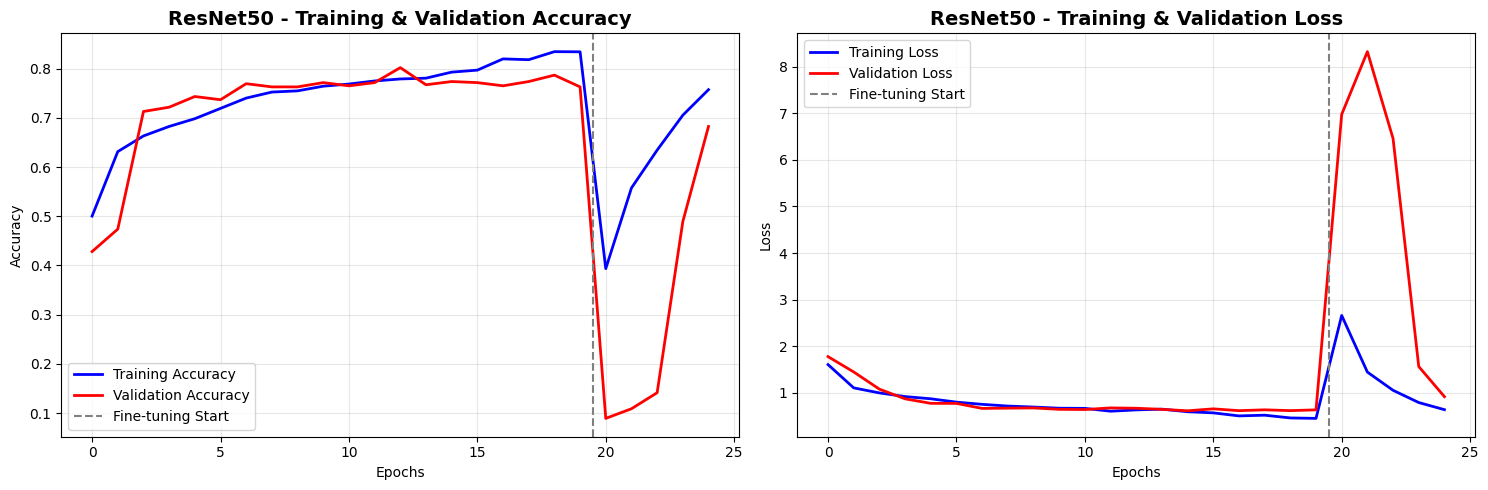


Evaluating ResNet50 on test set...



ResNet50 - FINAL RESULTS
TRAINING PHASE:
   Final Training Accuracy:   0.7574
   Final Training Loss:       0.6415
   Final Validation Accuracy: 0.6826
   Final Validation Loss:     0.9201

TEST PHASE:
   Test Accuracy:             0.0826
   Test Loss:                 6.9310

PERFORMANCE SUMMARY:
   Accuracy Drop (Val -> Test): +0.6000
   Loss Increase (Val -> Test): +6.0110
   Potential overfitting - consider more regularization
ResNet50 model saved as 'saved_models/ResNet50_betel_disease.h5'


In [34]:
print("\n" + "="*80)
print("1. TRAINING AND EVALUATING RESNET50")
print("="*80)

# Create ResNet50 model
resnet_model, resnet_base = create_resnet50_model()
print("ResNet50 model created successfully!")
print(f"   Total parameters: {resnet_model.count_params():,}")

# Define callbacks
resnet_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_ResNet50.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training ResNet50 with frozen base model...")
resnet_history = resnet_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=resnet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(resnet_history, "ResNet50_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning ResNet50...")
resnet_base.trainable = True
fine_tune_at = len(resnet_base.layers) // 2

for layer in resnet_base.layers[:fine_tune_at]:
    layer.trainable = False

resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

resnet_history_fine = resnet_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=resnet_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=resnet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(resnet_history_fine, "ResNet50_phase2")

# Plot training history
plot_training_history(resnet_history, resnet_history_fine, "ResNet50")

# Evaluate on test set
print("\nEvaluating ResNet50 on test set...")
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("ResNet50", resnet_history, resnet_history_fine, resnet_test_loss, resnet_test_accuracy)

# Store results
all_models_results["ResNet50"] = {
    'train_accuracy': resnet_history_fine.history['accuracy'][-1],
    'train_loss': resnet_history_fine.history['loss'][-1],
    'val_accuracy': resnet_history_fine.history['val_accuracy'][-1],
    'val_loss': resnet_history_fine.history['val_loss'][-1],
    'test_accuracy': resnet_test_accuracy,
    'test_loss': resnet_test_loss
}

# Save model
resnet_model.save('saved_models/ResNet50_betel_disease.h5')
print("ResNet50 model saved as 'saved_models/ResNet50_betel_disease.h5'")

In [35]:
## Train - MobileNet V3


5. TRAINING AND EVALUATING MOBILENET V3
MobileNetV3 model created successfully!
   Total parameters: 1,016,695

Phase 1: Training MobileNetV3 with frozen base model...
Epoch 1/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.3496 - loss: 1.8251
Epoch 1: val_accuracy improved from None to 0.16304, saving model to saved_models/best_MobileNetV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 103s 677ms/step - accuracy: 0.4474 - loss: 1.4912 - val_accuracy: 0.1630 - val_loss: 2.2134 - learning_rate: 0.0010
Epoch 2/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.5756 - loss: 1.1883
Epoch 2: val_accuracy did not improve from 0.16304
115/115 ━━━━━━━━━━━━━━━━━━━━ 139s 646ms/step - accuracy: 0.5907 - loss: 1.1396 - val_accuracy: 0.1065 - val_loss: 2.4102 - learning_rate: 0.0010
Epoch 3/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.6317 - loss: 1.0544
Epoch 3: val_accuracy improved from 0.16304 to 0.18696, saving model to saved_models/best_MobileNetV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 142s 646ms/step - accuracy: 0.6285 - loss: 1.0377 - val_accuracy: 0.1870 - val_loss: 2.3718 - learning_rate: 0.0010
Epoch 4/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.6313 - loss: 0.9983
Epoch 4: val_accuracy improved from 0.18696 to 0.30870, saving model to saved_models/best_MobileNetV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 137s 612ms/step - accuracy: 0.6416 - loss: 0.9910 - val_accuracy: 0.3087 - val_loss: 2.0013 - learning_rate: 0.0010
Epoch 5/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.6586 - loss: 0.9362
Epoch 5: val_accuracy improved from 0.30870 to 0.53043, saving model to saved_models/best_MobileNetV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 148s 661ms/step - accuracy: 0.6679 - loss: 0.9218 - val_accuracy: 0.5304 - val_loss: 1.2101 - learning_rate: 0.0010
Epoch 6/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.6841 - loss: 0.8945
Epoch 6: val_accuracy improved from 0.53043 to 0.62174, saving model to saved_models/best_MobileNetV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 142s 664ms/step - accuracy: 0.6723 - loss: 0.8977 - val_accuracy: 0.6217 - val_loss: 0.9627 - learning_rate: 0.0010
Epoch 7/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.6796 - loss: 0.8987
Epoch 7: val_accuracy improved from 0.62174 to 0.76087, saving model to saved_models/best_MobileNetV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 144s 673ms/step - accuracy: 0.6818 - loss: 0.8674 - val_accuracy: 0.7609 - val_loss: 0.7038 - learning_rate: 0.0010
Epoch 8/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.7025 - loss: 0.8481
Epoch 8: val_accuracy did not improve from 0.76087
115/115 ━━━━━━━━━━━━━━━━━━━━ 91s 666ms/step - accuracy: 0.6979 - loss: 0.8554 - val_accuracy: 0.7435 - val_loss: 0.6727 - learning_rate: 0.0010
Epoch 9/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.6925 - loss: 0.8323
Epoch 9: val_accuracy did not improve from 0.76087
115/115 ━━━━━━━━━━━━━━━━━━━━ 144s 681ms/step - accuracy: 0.6979 - loss: 0.8420 - val_accuracy: 0.7565 - val_loss: 0.6169 - learning_rate: 0.0010
Epoch 10/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.6984 - loss: 0.8540
Epoch 10: val_accuracy improved from 0.76087 to 0.76304, saving model to saved_models/best_MobileNetV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 89s 643ms/step - accuracy: 0.6867 - loss: 0.8485 - val_accuracy: 0.7630 - val_loss: 0.5959 - learning_rate: 0.0010
Epoch 11/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.7014 - loss: 0.8220
Epoch 11: val_accuracy improved from 0.76304 to 0.78261, saving model to saved_models/best_MobileNetV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 142s 646ms/step - accuracy: 0.7090 - loss: 0.8054 - val_accuracy: 0.7826 - val_loss: 0.5848 - learning_rate: 0.0010
Epoch 12/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.7056 - loss: 0.8324
Epoch 12: val_accuracy did not improve from 0.78261
115/115 ━━━━━━━━━━━━━━━━━━━━ 143s 651ms/step - accuracy: 0.7011 - loss: 0.8295 - val_accuracy: 0.7543 - val_loss: 0.6055 - learning_rate: 0.0010
Epoch 13/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7156 - loss: 0.7974
Epoch 13: val_accuracy did not improve from 0.78261
115/115 ━━━━━━━━━━━━━━━━━━━━ 91s 666ms/step - accuracy: 0.7215 - loss: 0.7780 - val_accuracy: 0.7783 - val_loss: 0.5616 - learning_rate: 0.0010
Epoch 14/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.7271 - loss: 0.7954
Epoch 14: val_accuracy did not improve from 0.78261
115/115 ━━━━━━━━━━━━━━━━━━━━ 142s 667ms/step - accuracy: 0.7294 - loss: 0.7750 - val_accuracy: 0.7826 - val_loss: 0.5884 - learning_rate: 0.001

115/115 ━━━━━━━━━━━━━━━━━━━━ 143s 668ms/step - accuracy: 0.7242 - loss: 0.7531 - val_accuracy: 0.8087 - val_loss: 0.5204 - learning_rate: 0.0010
Epoch 16/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.7531 - loss: 0.7208
Epoch 16: val_accuracy did not improve from 0.80870
115/115 ━━━━━━━━━━━━━━━━━━━━ 138s 639ms/step - accuracy: 0.7397 - loss: 0.7432 - val_accuracy: 0.7804 - val_loss: 0.5774 - learning_rate: 0.0010
Epoch 17/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.7427 - loss: 0.7321
Epoch 17: val_accuracy did not improve from 0.80870
115/115 ━━━━━━━━━━━━━━━━━━━━ 145s 664ms/step - accuracy: 0.7367 - loss: 0.7391 - val_accuracy: 0.7957 - val_loss: 0.5354 - learning_rate: 0.0010
Epoch 18/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7504 - loss: 0.7563
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: val_accuracy did not improve from 0.80870
115/115 ━━━━━━━━━━━━━━━━━━━━ 141s 655ms/step - accuracy: 0.7427 

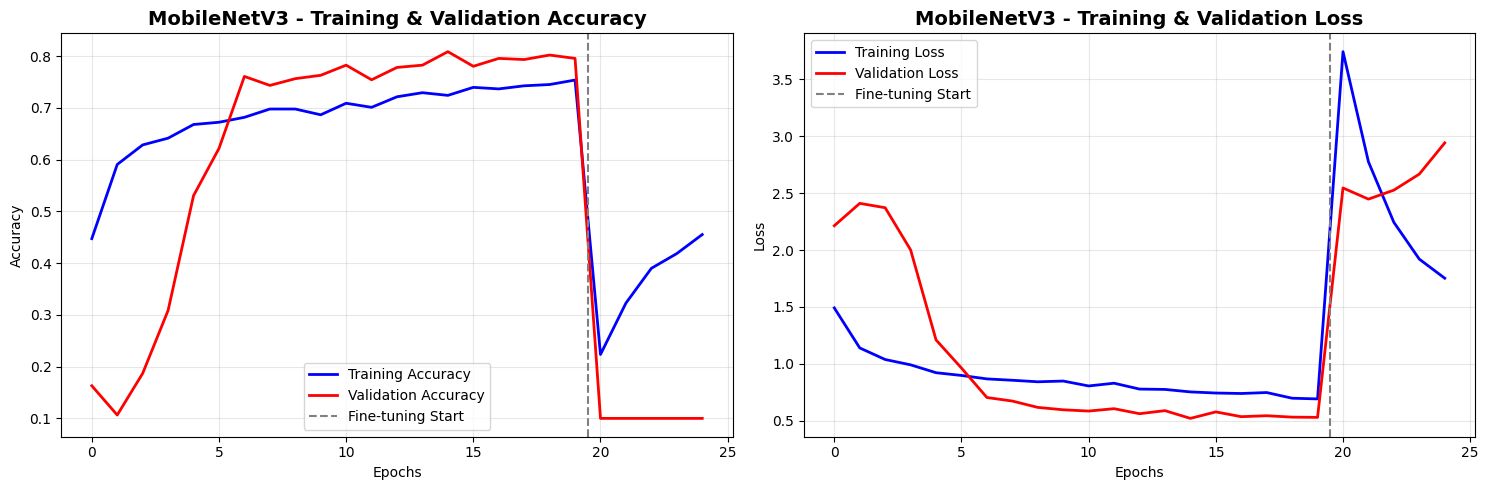


Evaluating MobileNetV3 on test set...



MobileNetV3 - FINAL RESULTS
TRAINING PHASE:
   Final Training Accuracy:   0.4553
   Final Training Loss:       1.7523
   Final Validation Accuracy: 0.1000
   Final Validation Loss:     2.9416

TEST PHASE:
   Test Accuracy:             0.0978
   Test Loss:                 2.5510

PERFORMANCE SUMMARY:
   Accuracy Drop (Val -> Test): +0.0022
   Loss Increase (Val -> Test): -0.3905
   Good generalization - model is not overfitting significantly
MobileNetV3 model saved as 'saved_models/MobileNetV3_betel_disease.h5'


In [36]:
print("\n" + "="*80)
print("5. TRAINING AND EVALUATING MOBILENET V3")
print("="*80)

# Create MobileNetV3 model
mobilenet_model, mobilenet_base = create_mobilenetv3_model()
print("MobileNetV3 model created successfully!")
print(f"   Total parameters: {mobilenet_model.count_params():,}")

# Define callbacks
mobilenet_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_MobileNetV3.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training MobileNetV3 with frozen base model...")
mobilenet_history = mobilenet_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=mobilenet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(mobilenet_history, "MobileNetV3_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning MobileNetV3...")
mobilenet_base.trainable = True

# Use lower learning rate for fine-tuning
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

mobilenet_history_fine = mobilenet_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=mobilenet_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=mobilenet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(mobilenet_history_fine, "MobileNetV3_phase2")

# Plot training history
plot_training_history(mobilenet_history, mobilenet_history_fine, "MobileNetV3")

# Evaluate on test set
print("\nEvaluating MobileNetV3 on test set...")
mobilenet_test_loss, mobilenet_test_accuracy = mobilenet_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("MobileNetV3", mobilenet_history, mobilenet_history_fine, mobilenet_test_loss, mobilenet_test_accuracy)

# Store results
all_models_results["MobileNetV3"] = {
    'train_accuracy': mobilenet_history_fine.history['accuracy'][-1],
    'train_loss': mobilenet_history_fine.history['loss'][-1],
    'val_accuracy': mobilenet_history_fine.history['val_accuracy'][-1],
    'val_loss': mobilenet_history_fine.history['val_loss'][-1],
    'test_accuracy': mobilenet_test_accuracy,
    'test_loss': mobilenet_test_loss
}

# Save model
mobilenet_model.save('saved_models/MobileNetV3_betel_disease.h5')
print("MobileNetV3 model saved as 'saved_models/MobileNetV3_betel_disease.h5'")

In [37]:
## Train - DENSENET121 


6. TRAINING AND EVALUATING DENSENET121
DenseNet121 model created successfully!
   Total parameters: 7,572,039

Phase 1: Training DenseNet121 with frozen base model...
Epoch 1/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6187 - loss: 1.2352
Epoch 1: val_accuracy improved from None to 0.85000, saving model to saved_models/best_DenseNet121.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 576s 5s/step - accuracy: 0.7392 - loss: 0.8812 - val_accuracy: 0.8500 - val_loss: 0.4656 - learning_rate: 5.0000e-04
Epoch 2/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8543 - loss: 0.4563
Epoch 2: val_accuracy improved from 0.85000 to 0.91522, saving model to saved_models/best_DenseNet121.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 551s 5s/step - accuracy: 0.8599 - loss: 0.4208 - val_accuracy: 0.9152 - val_loss: 0.2426 - learning_rate: 5.0000e-04
Epoch 3/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8700 - loss: 0.3775
Epoch 3: val_accuracy improved from 0.91522 to 0.93043, saving model to saved_models/best_DenseNet121.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 583s 5s/step - accuracy: 0.8773 - loss: 0.3489 - val_accuracy: 0.9304 - val_loss: 0.1901 - learning_rate: 5.0000e-04
Epoch 4/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9128 - loss: 0.2661
Epoch 4: val_accuracy improved from 0.93043 to 0.93696, saving model to saved_models/best_DenseNet121.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 568s 4s/step - accuracy: 0.9026 - loss: 0.2747 - val_accuracy: 0.9370 - val_loss: 0.1849 - learning_rate: 5.0000e-04
Epoch 5/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9198 - loss: 0.2481
Epoch 5: val_accuracy improved from 0.93696 to 0.95000, saving model to saved_models/best_DenseNet121.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 519s 4s/step - accuracy: 0.9157 - loss: 0.2416 - val_accuracy: 0.9500 - val_loss: 0.1599 - learning_rate: 5.0000e-04
Epoch 6/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9252 - loss: 0.2165
Epoch 6: val_accuracy did not improve from 0.95000
115/115 ━━━━━━━━━━━━━━━━━━━━ 510s 4s/step - accuracy: 0.9225 - loss: 0.2274 - val_accuracy: 0.9500 - val_loss: 0.1570 - learning_rate: 5.0000e-04
Epoch 7/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9340 - loss: 0.1861
Epoch 7: val_accuracy did not improve from 0.95000
115/115 ━━━━━━━━━━━━━━━━━━━━ 563s 5s/step - accuracy: 0.9277 - loss: 0.1942 - val_accuracy: 0.9478 - val_loss: 0.1560 - learning_rate: 5.0000e-04
Epoch 8/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9207 - loss: 0.1944
Epoch 8: val_accuracy did not improve from 0.95000
115/115 ━━━━━━━━━━━━━━━━━━━━ 543s 5s/step - accuracy: 0.9225 - loss: 0.1930 - val_accuracy: 0.9478 - val_loss: 0.1578 - learning_rate: 5.0000e-04
Epoch 9/

115/115 ━━━━━━━━━━━━━━━━━━━━ 589s 5s/step - accuracy: 0.9434 - loss: 0.1578 - val_accuracy: 0.9522 - val_loss: 0.1405 - learning_rate: 5.0000e-04
Epoch 11/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9471 - loss: 0.1503
Epoch 11: val_accuracy improved from 0.95217 to 0.95435, saving model to saved_models/best_DenseNet121.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 567s 5s/step - accuracy: 0.9418 - loss: 0.1530 - val_accuracy: 0.9543 - val_loss: 0.1415 - learning_rate: 5.0000e-04
Epoch 12/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9457 - loss: 0.1321
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: val_accuracy improved from 0.95435 to 0.96087, saving model to saved_models/best_DenseNet121.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 602s 5s/step - accuracy: 0.9464 - loss: 0.1390 - val_accuracy: 0.9609 - val_loss: 0.1506 - learning_rate: 5.0000e-04
Epoch 13/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9550 - loss: 0.1207
Epoch 13: val_accuracy did not improve from 0.96087
115/115 ━━━━━━━━━━━━━━━━━━━━ 585s 5s/step - accuracy: 0.9557 - loss: 0.1193 - val_accuracy: 0.9565 - val_loss: 0.1411 - learning_rate: 2.5000e-04
Epoch 14/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9547 - loss: 0.1053
Epoch 14: val_accuracy improved from 0.96087 to 0.96304, saving model to saved_models/best_DenseNet121.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 522s 4s/step - accuracy: 0.9500 - loss: 0.1156 - val_accuracy: 0.9630 - val_loss: 0.1343 - learning_rate: 2.5000e-04
Epoch 15/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9482 - loss: 0.1317
Epoch 15: val_accuracy did not improve from 0.96304
115/115 ━━━━━━━━━━━━━━━━━━━━ 553s 4s/step - accuracy: 0.9483 - loss: 0.1271 - val_accuracy: 0.9609 - val_loss: 0.1351 - learning_rate: 2.5000e-04
Epoch 16/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9572 - loss: 0.1010
Epoch 16: val_accuracy did not improve from 0.96304
115/115 ━━━━━━━━━━━━━━━━━━━━ 542s 5s/step - accuracy: 0.9530 - loss: 0.1070 - val_accuracy: 0.9522 - val_loss: 0.1308 - learning_rate: 2.5000e-04
Epoch 17/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9621 - loss: 0.1087
Epoch 17: val_accuracy improved from 0.96304 to 0.96739, saving model to saved_models/best_DenseNet121.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 562s 5s/step - accuracy: 0.9625 - loss: 0.1079 - val_accuracy: 0.9674 - val_loss: 0.1301 - learning_rate: 2.5000e-04
Epoch 18/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9624 - loss: 0.0932
Epoch 18: val_accuracy did not improve from 0.96739
115/115 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.9606 - loss: 0.0974 - val_accuracy: 0.9565 - val_loss: 0.1471 - learning_rate: 2.5000e-04
Epoch 19/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9645 - loss: 0.0964
Epoch 19: val_accuracy did not improve from 0.96739
115/115 ━━━━━━━━━━━━━━━━━━━━ 592s 5s/step - accuracy: 0.9625 - loss: 0.0963 - val_accuracy: 0.9609 - val_loss: 0.1489 - learning_rate: 2.5000e-04
Epoch 20/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9723 - loss: 0.0880
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 20: val_accuracy did not improve from 0.96739
115/115 ━━━━━━━━━━━━━━━━━━━━ 572s 5s/step - accuracy: 0.9682 - loss: 0

115/115 ━━━━━━━━━━━━━━━━━━━━ 2481s 21s/step - accuracy: 0.9772 - loss: 0.0495 - val_accuracy: 0.9696 - val_loss: 0.1075 - learning_rate: 1.0000e-05
Epoch 32/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9809 - loss: 0.0480 
Epoch 32: val_accuracy improved from 0.96957 to 0.97174, saving model to saved_models/best_DenseNet121.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 2623s 23s/step - accuracy: 0.9796 - loss: 0.0470 - val_accuracy: 0.9717 - val_loss: 0.1103 - learning_rate: 1.0000e-05
Epoch 33/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 174s/step - accuracy: 0.9895 - loss: 0.0355  
Epoch 33: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 33: val_accuracy did not improve from 0.97174
115/115 ━━━━━━━━━━━━━━━━━━━━ 19922s 174s/step - accuracy: 0.9878 - loss: 0.0369 - val_accuracy: 0.9674 - val_loss: 0.1177 - learning_rate: 1.0000e-05
Epoch 34/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9821 - loss: 0.0326 
Epoch 34: val_accuracy did not improve from 0.97174
115/115 ━━━━━━━━━━━━━━━━━━━━ 2179s 18s/step - accuracy: 0.9864 - loss: 0.0315 - val_accuracy: 0.9630 - val_loss: 0.1147 - learning_rate: 5.0000e-06
Epoch 35/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9859 - loss: 0.0367 
Epoch 35: val_accuracy did not improve from 0.97174
115/115 ━━━━━━━━━━━━━━━━━━━━ 2236s 19s/step - accuracy

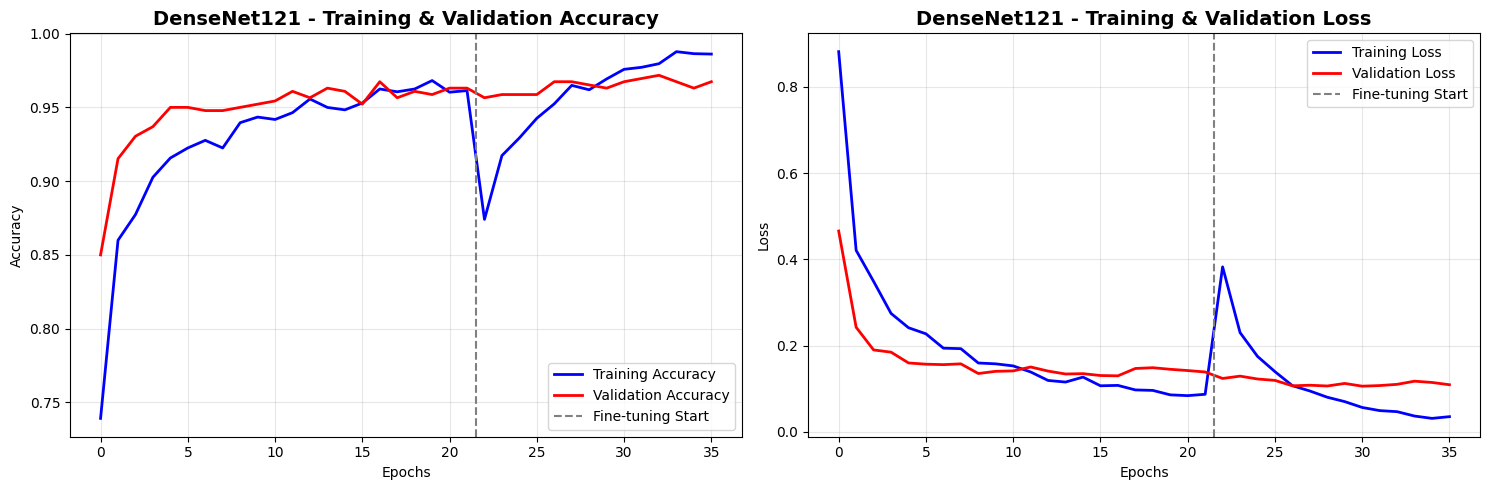


Evaluating DenseNet121 on test set...



DenseNet121 - FINAL RESULTS
TRAINING PHASE:
   Final Training Accuracy:   0.9861
   Final Training Loss:       0.0355
   Final Validation Accuracy: 0.9674
   Final Validation Loss:     0.1094

TEST PHASE:
   Test Accuracy:             0.9630
   Test Loss:                 0.1158

PERFORMANCE SUMMARY:
   Accuracy Drop (Val -> Test): +0.0043
   Loss Increase (Val -> Test): +0.0064
   Good generalization - model is not overfitting significantly
DenseNet121 model saved as 'saved_models/DenseNet121_betel_disease.h5'


In [38]:
print("\n" + "="*80)
print("6. TRAINING AND EVALUATING DENSENET121")
print("="*80)

# Create DenseNet121 model
densenet_model, densenet_base = create_densenet121_model()
print("DenseNet121 model created successfully!")
print(f"   Total parameters: {densenet_model.count_params():,}")

# Define callbacks
densenet_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_DenseNet121.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training DenseNet121 with frozen base model...")
densenet_history = densenet_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=densenet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(densenet_history, "DenseNet121_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning DenseNet121...")
densenet_base.trainable = True

# Use lower learning rate for fine-tuning
densenet_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

densenet_history_fine = densenet_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=densenet_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=densenet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(densenet_history_fine, "DenseNet121_phase2")

# Plot training history
plot_training_history(densenet_history, densenet_history_fine, "DenseNet121")

# Evaluate on test set
print("\nEvaluating DenseNet121 on test set...")
densenet_test_loss, densenet_test_accuracy = densenet_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("DenseNet121", densenet_history, densenet_history_fine, densenet_test_loss, densenet_test_accuracy)

# Store results
all_models_results["DenseNet121"] = {
    'train_accuracy': densenet_history_fine.history['accuracy'][-1],
    'train_loss': densenet_history_fine.history['loss'][-1],
    'val_accuracy': densenet_history_fine.history['val_accuracy'][-1],
    'val_loss': densenet_history_fine.history['val_loss'][-1],
    'test_accuracy': densenet_test_accuracy,
    'test_loss': densenet_test_loss
}

# Save model
densenet_model.save('saved_models/DenseNet121_betel_disease.h5')
print("DenseNet121 model saved as 'saved_models/DenseNet121_betel_disease.h5'")

In [39]:
## Train - GOOGLENET 


7. TRAINING AND EVALUATING INCEPTIONV3
InceptionV3 model created successfully!
   Total parameters: 22,865,703

Phase 1: Training InceptionV3 with frozen base model...
Epoch 1/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6346 - loss: 1.3425
Epoch 1: val_accuracy improved from None to 0.86304, saving model to saved_models/best_InceptionV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 402s 3s/step - accuracy: 0.7302 - loss: 1.0030 - val_accuracy: 0.8630 - val_loss: 0.4165 - learning_rate: 5.0000e-04
Epoch 2/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8667 - loss: 0.4311
Epoch 2: val_accuracy improved from 0.86304 to 0.89130, saving model to saved_models/best_InceptionV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 477s 4s/step - accuracy: 0.8684 - loss: 0.4154 - val_accuracy: 0.8913 - val_loss: 0.2820 - learning_rate: 5.0000e-04
Epoch 3/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9090 - loss: 0.2841
Epoch 3: val_accuracy improved from 0.89130 to 0.91087, saving model to saved_models/best_InceptionV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.9029 - loss: 0.2808 - val_accuracy: 0.9109 - val_loss: 0.2792 - learning_rate: 5.0000e-04
Epoch 4/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9273 - loss: 0.2004
Epoch 4: val_accuracy improved from 0.91087 to 0.91522, saving model to saved_models/best_InceptionV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.9279 - loss: 0.1960 - val_accuracy: 0.9152 - val_loss: 0.2619 - learning_rate: 5.0000e-04
Epoch 5/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9377 - loss: 0.1643
Epoch 5: val_accuracy did not improve from 0.91522
115/115 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step - accuracy: 0.9339 - loss: 0.1609 - val_accuracy: 0.9087 - val_loss: 0.2721 - learning_rate: 5.0000e-04
Epoch 6/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9473 - loss: 0.1337
Epoch 6: val_accuracy improved from 0.91522 to 0.91739, saving model to saved_models/best_InceptionV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 386s 3s/step - accuracy: 0.9421 - loss: 0.1405 - val_accuracy: 0.9174 - val_loss: 0.2615 - learning_rate: 5.0000e-04
Epoch 7/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9400 - loss: 0.1350
Epoch 7: val_accuracy improved from 0.91739 to 0.91957, saving model to saved_models/best_InceptionV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.9453 - loss: 0.1426 - val_accuracy: 0.9196 - val_loss: 0.2752 - learning_rate: 5.0000e-04
Epoch 8/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9638 - loss: 0.1136
Epoch 8: val_accuracy did not improve from 0.91957
115/115 ━━━━━━━━━━━━━━━━━━━━ 425s 4s/step - accuracy: 0.9589 - loss: 0.1124 - val_accuracy: 0.9109 - val_loss: 0.2765 - learning_rate: 5.0000e-04
Epoch 9/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9616 - loss: 0.0881
Epoch 9: val_accuracy did not improve from 0.91957
115/115 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.9570 - loss: 0.0960 - val_accuracy: 0.9087 - val_loss: 0.2495 - learning_rate: 5.0000e-04
Epoch 10/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9623 - loss: 0.0926
Epoch 10: val_accuracy improved from 0.91957 to 0.92826, saving model to saved_models/best_InceptionV3.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 360s 3s/step - accuracy: 0.9595 - loss: 0.0981 - val_accuracy: 0.9283 - val_loss: 0.2402 - learning_rate: 5.0000e-04
Epoch 11/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9734 - loss: 0.0813
Epoch 11: val_accuracy did not improve from 0.92826
115/115 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.9685 - loss: 0.0772 - val_accuracy: 0.9065 - val_loss: 0.2862 - learning_rate: 5.0000e-04
Epoch 12/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9704 - loss: 0.0816
Epoch 12: val_accuracy did not improve from 0.92826
115/115 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.9695 - loss: 0.0778 - val_accuracy: 0.9087 - val_loss: 0.2973 - learning_rate: 5.0000e-04
Epoch 13/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9669 - loss: 0.0715
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: val_accuracy did not improve from 0.92826
115/115 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.9728 - loss: 0

115/115 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.9753 - loss: 0.0519 - val_accuracy: 0.9348 - val_loss: 0.2276 - learning_rate: 2.5000e-04
Epoch 15/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9747 - loss: 0.0510
Epoch 15: val_accuracy did not improve from 0.93478
115/115 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.9799 - loss: 0.0455 - val_accuracy: 0.9283 - val_loss: 0.2443 - learning_rate: 2.5000e-04
Epoch 16/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9860 - loss: 0.0350
Epoch 16: val_accuracy did not improve from 0.93478
115/115 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - accuracy: 0.9826 - loss: 0.0381 - val_accuracy: 0.9326 - val_loss: 0.2472 - learning_rate: 2.5000e-04
Epoch 17/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9854 - loss: 0.0367
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 17: val_accuracy did not improve from 0.93478
115/115 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.9829 - loss: 0

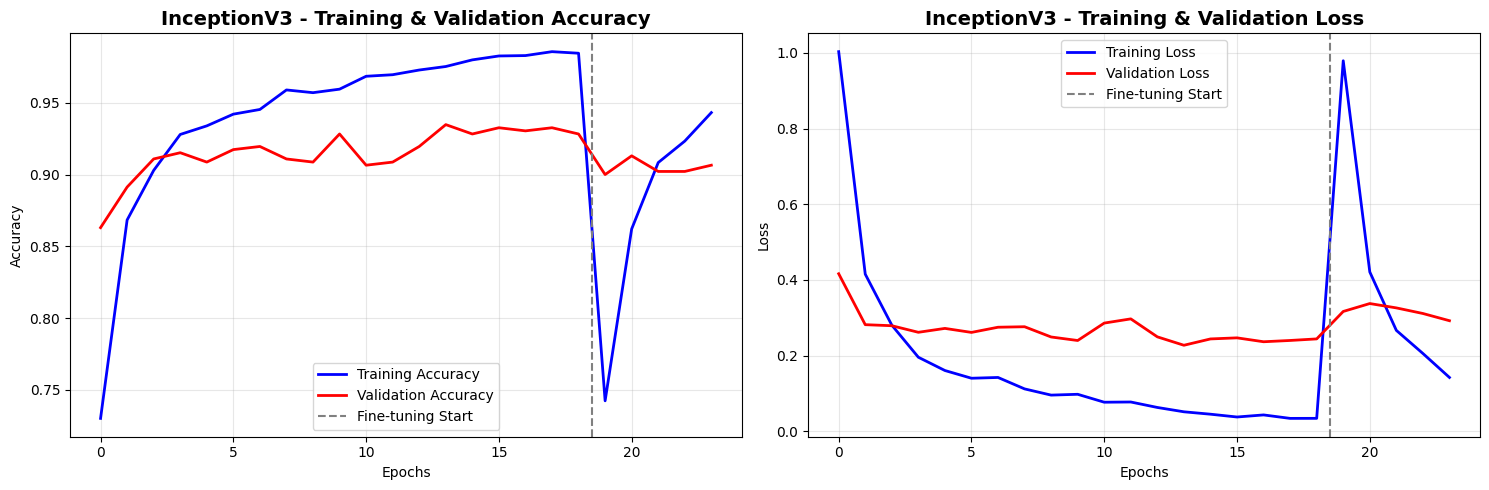


Evaluating InceptionV3 on test set...



InceptionV3 - FINAL RESULTS
TRAINING PHASE:
   Final Training Accuracy:   0.9432
   Final Training Loss:       0.1426
   Final Validation Accuracy: 0.9065
   Final Validation Loss:     0.2924

TEST PHASE:
   Test Accuracy:             0.8957
   Test Loss:                 0.4056

PERFORMANCE SUMMARY:
   Accuracy Drop (Val -> Test): +0.0109
   Loss Increase (Val -> Test): +0.1132
   Potential overfitting - consider more regularization
InceptionV3 model saved as 'saved_models/InceptionV3_betel_disease.h5'


In [40]:
print("\n" + "="*80)
print("7. TRAINING AND EVALUATING INCEPTIONV3")
print("="*80)

# Create InceptionV3 model
inception_model, inception_base = create_googlenet_model()
print("InceptionV3 model created successfully!")
print(f"   Total parameters: {inception_model.count_params():,}")

# Define callbacks
inception_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_InceptionV3.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training InceptionV3 with frozen base model...")
inception_history = inception_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=inception_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(inception_history, "InceptionV3_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning InceptionV3...")
inception_base.trainable = True

# Use lower learning rate for fine-tuning
inception_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

inception_history_fine = inception_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=inception_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=inception_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(inception_history_fine, "InceptionV3_phase2")

# Plot training history
plot_training_history(inception_history, inception_history_fine, "InceptionV3")

# Evaluate on test set
print("\nEvaluating InceptionV3 on test set...")
inception_test_loss, inception_test_accuracy = inception_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("InceptionV3", inception_history, inception_history_fine, inception_test_loss, inception_test_accuracy)

# Store results
all_models_results["InceptionV3"] = {
    'train_accuracy': inception_history_fine.history['accuracy'][-1],
    'train_loss': inception_history_fine.history['loss'][-1],
    'val_accuracy': inception_history_fine.history['val_accuracy'][-1],
    'val_loss': inception_history_fine.history['val_loss'][-1],
    'test_accuracy': inception_test_accuracy,
    'test_loss': inception_test_loss
}

# Save model
inception_model.save('saved_models/InceptionV3_betel_disease.h5')
print("InceptionV3 model saved as 'saved_models/InceptionV3_betel_disease.h5'")

In [23]:
## Train - CONVNEXT 

In [ ]:
print("\n" + "="*80)
print("3. TRAINING AND EVALUATING CONVNEXT")
print("="*80)

# Create ConvNeXt model
convnext_model, convnext_base = create_convnext_model()
print("ConvNeXt model created successfully!")
print(f"   Total parameters: {convnext_model.count_params():,}")

# Define callbacks
convnext_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_ConvNeXt.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training ConvNeXt with frozen base model...")
convnext_history = convnext_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=convnext_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(convnext_history, "ConvNeXt_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning ConvNeXt...")
convnext_base.trainable = True

# Use lower learning rate for fine-tuning
convnext_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

convnext_history_fine = convnext_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=convnext_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=convnext_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(convnext_history_fine, "ConvNeXt_phase2")

# Plot training history
plot_training_history(convnext_history, convnext_history_fine, "ConvNeXt")

# Evaluate on test set
print("\nEvaluating ConvNeXt on test set...")
convnext_test_loss, convnext_test_accuracy = convnext_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("ConvNeXt", convnext_history, convnext_history_fine, convnext_test_loss, convnext_test_accuracy)

# Store results
all_models_results["ConvNeXt"] = {
    'train_accuracy': convnext_history_fine.history['accuracy'][-1],
    'train_loss': convnext_history_fine.history['loss'][-1],
    'val_accuracy': convnext_history_fine.history['val_accuracy'][-1],
    'val_loss': convnext_history_fine.history['val_loss'][-1],
    'test_accuracy': convnext_test_accuracy,
    'test_loss': convnext_test_loss
}

# Save model
convnext_model.save('saved_models/ConvNeXt_betel_disease.h5')
print("ConvNeXt model saved as 'saved_models/ConvNeXt_betel_disease.h5'")

In [22]:
## Train - VGG 16


7. TRAINING AND EVALUATING VGG16
VGG16 model created successfully!
   Total parameters: 14,985,031

Phase 1: Training VGG16 with frozen base model...
Epoch 1/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.2093 - loss: 2.7153 
Epoch 1: val_accuracy improved from None to 0.42826, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 1573s 14s/step - accuracy: 0.2853 - loss: 2.2732 - val_accuracy: 0.4283 - val_loss: 1.5776 - learning_rate: 1.0000e-04
Epoch 2/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4535 - loss: 1.6146 
Epoch 2: val_accuracy improved from 0.42826 to 0.75652, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 1573s 14s/step - accuracy: 0.4754 - loss: 1.5060 - val_accuracy: 0.7565 - val_loss: 1.1065 - learning_rate: 1.0000e-04
Epoch 3/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5721 - loss: 1.2679 
Epoch 3: val_accuracy improved from 0.75652 to 0.81957, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 1572s 14s/step - accuracy: 0.5706 - loss: 1.2527 - val_accuracy: 0.8196 - val_loss: 0.7135 - learning_rate: 1.0000e-04
Epoch 4/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6109 - loss: 1.1645 
Epoch 4: val_accuracy improved from 0.81957 to 0.85217, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 1580s 13s/step - accuracy: 0.6312 - loss: 1.1025 - val_accuracy: 0.8522 - val_loss: 0.4946 - learning_rate: 1.0000e-04
Epoch 5/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6548 - loss: 1.0634 
Epoch 5: val_accuracy improved from 0.85217 to 0.86957, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 1575s 13s/step - accuracy: 0.6598 - loss: 1.0201 - val_accuracy: 0.8696 - val_loss: 0.3971 - learning_rate: 1.0000e-04
Epoch 6/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6773 - loss: 0.9537 
Epoch 6: val_accuracy improved from 0.86957 to 0.87826, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 1569s 13s/step - accuracy: 0.6878 - loss: 0.9696 - val_accuracy: 0.8783 - val_loss: 0.3554 - learning_rate: 1.0000e-04
Epoch 7/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7017 - loss: 0.9571 
Epoch 7: val_accuracy improved from 0.87826 to 0.89130, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 1545s 13s/step - accuracy: 0.7068 - loss: 0.9513 - val_accuracy: 0.8913 - val_loss: 0.3266 - learning_rate: 1.0000e-04
Epoch 8/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7175 - loss: 0.9256 
Epoch 8: val_accuracy improved from 0.89130 to 0.89565, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 1600s 13s/step - accuracy: 0.7199 - loss: 0.8943 - val_accuracy: 0.8957 - val_loss: 0.3130 - learning_rate: 1.0000e-04
Epoch 9/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7249 - loss: 0.8690 
Epoch 9: val_accuracy did not improve from 0.89565
115/115 ━━━━━━━━━━━━━━━━━━━━ 1558s 13s/step - accuracy: 0.7275 - loss: 0.8494 - val_accuracy: 0.8957 - val_loss: 0.3014 - learning_rate: 1.0000e-04
Epoch 10/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7359 - loss: 0.8565 
Epoch 10: val_accuracy did not improve from 0.89565
115/115 ━━━━━━━━━━━━━━━━━━━━ 1561s 13s/step - accuracy: 0.7305 - loss: 0.8450 - val_accuracy: 0.8957 - val_loss: 0.2903 - learning_rate: 1.0000e-04
Epoch 11/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7332 - loss: 0.8338 
Epoch 11: val_accuracy improved from 0.89565 to 0.91087, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 1533s 13s/step - accuracy: 0.7482 - loss: 0.7829 - val_accuracy: 0.9109 - val_loss: 0.2793 - learning_rate: 1.0000e-04
Epoch 12/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7601 - loss: 0.7574 
Epoch 12: val_accuracy did not improve from 0.91087
115/115 ━━━━━━━━━━━━━━━━━━━━ 1539s 13s/step - accuracy: 0.7547 - loss: 0.7665 - val_accuracy: 0.9043 - val_loss: 0.2745 - learning_rate: 1.0000e-04
Epoch 13/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7509 - loss: 0.8009 
Epoch 13: val_accuracy did not improve from 0.91087
115/115 ━━━━━━━━━━━━━━━━━━━━ 1585s 13s/step - accuracy: 0.7599 - loss: 0.7404 - val_accuracy: 0.9087 - val_loss: 0.2654 - learning_rate: 1.0000e-04
Epoch 14/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7725 - loss: 0.7134 
Epoch 14: val_accuracy improved from 0.91087 to 0.91522, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 1601s 13s/step - accuracy: 0.7726 - loss: 0.7000 - val_accuracy: 0.9152 - val_loss: 0.2573 - learning_rate: 1.0000e-04
Epoch 15/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7794 - loss: 0.7635 
Epoch 15: val_accuracy improved from 0.91522 to 0.91957, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 1530s 13s/step - accuracy: 0.7843 - loss: 0.7067 - val_accuracy: 0.9196 - val_loss: 0.2493 - learning_rate: 1.0000e-04
Epoch 16/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7921 - loss: 0.6816 
Epoch 16: val_accuracy did not improve from 0.91957
115/115 ━━━━━━━━━━━━━━━━━━━━ 1529s 13s/step - accuracy: 0.7838 - loss: 0.6810 - val_accuracy: 0.9152 - val_loss: 0.2478 - learning_rate: 1.0000e-04
Epoch 17/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7800 - loss: 0.7008 
Epoch 17: val_accuracy did not improve from 0.91957
115/115 ━━━━━━━━━━━━━━━━━━━━ 1791s 15s/step - accuracy: 0.7852 - loss: 0.6673 - val_accuracy: 0.9130 - val_loss: 0.2489 - learning_rate: 1.0000e-04
Epoch 18/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7830 - loss: 0.6392 
Epoch 18: val_accuracy did not improve from 0.91957
115/115 ━━━━━━━━━━━━━━━━━━━━ 1831s 16s/step - accuracy: 0.7819 - loss: 0.6637 - val_accuracy: 0.9174 - val_loss: 0.2447 - learning_rate:

115/115 ━━━━━━━━━━━━━━━━━━━━ 1806s 15s/step - accuracy: 0.7816 - loss: 0.6270 - val_accuracy: 0.9239 - val_loss: 0.2406 - learning_rate: 1.0000e-04
Epoch 20/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7956 - loss: 0.6547 
Epoch 20: val_accuracy did not improve from 0.92391
115/115 ━━━━━━━━━━━━━━━━━━━━ 1820s 15s/step - accuracy: 0.7890 - loss: 0.6523 - val_accuracy: 0.9196 - val_loss: 0.2392 - learning_rate: 1.0000e-04
Epoch 21/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8038 - loss: 0.6438 
Epoch 21: val_accuracy did not improve from 0.92391
115/115 ━━━━━━━━━━━━━━━━━━━━ 1709s 15s/step - accuracy: 0.7955 - loss: 0.6268 - val_accuracy: 0.9239 - val_loss: 0.2315 - learning_rate: 1.0000e-04
Epoch 22/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7952 - loss: 0.6303 
Epoch 22: val_accuracy did not improve from 0.92391
115/115 ━━━━━━━━━━━━━━━━━━━━ 1506s 13s/step - accuracy: 0.7958 - loss: 0.6059 - val_accuracy: 0.9196 - val_loss: 0.2305 - learning_rate:

115/115 ━━━━━━━━━━━━━━━━━━━━ 2099s 18s/step - accuracy: 0.8605 - loss: 0.3904 - val_accuracy: 0.9261 - val_loss: 0.1958 - learning_rate: 1.0000e-05
Epoch 37/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8704 - loss: 0.3817 
Epoch 37: val_accuracy did not improve from 0.92609
115/115 ━━━━━━━━━━━━━━━━━━━━ 2049s 18s/step - accuracy: 0.8632 - loss: 0.3875 - val_accuracy: 0.9261 - val_loss: 0.1849 - learning_rate: 1.0000e-05
Epoch 38/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8915 - loss: 0.3310 
Epoch 38: val_accuracy improved from 0.92609 to 0.93261, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 2071s 18s/step - accuracy: 0.8953 - loss: 0.3229 - val_accuracy: 0.9326 - val_loss: 0.1859 - learning_rate: 1.0000e-05
Epoch 39/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.8900 - loss: 0.2917 
Epoch 39: val_accuracy improved from 0.93261 to 0.93913, saving model to saved_models/best_VGG16.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 2057s 18s/step - accuracy: 0.8945 - loss: 0.2912 - val_accuracy: 0.9391 - val_loss: 0.1716 - learning_rate: 1.0000e-05
Epoch 40/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9046 - loss: 0.2485 
Epoch 40: val_accuracy did not improve from 0.93913
115/115 ━━━━━━━━━━━━━━━━━━━━ 2040s 18s/step - accuracy: 0.9056 - loss: 0.2427 - val_accuracy: 0.9370 - val_loss: 0.1692 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 40.
Training history saved to training_history/VGG16_phase2_history_20251203_095054.pkl


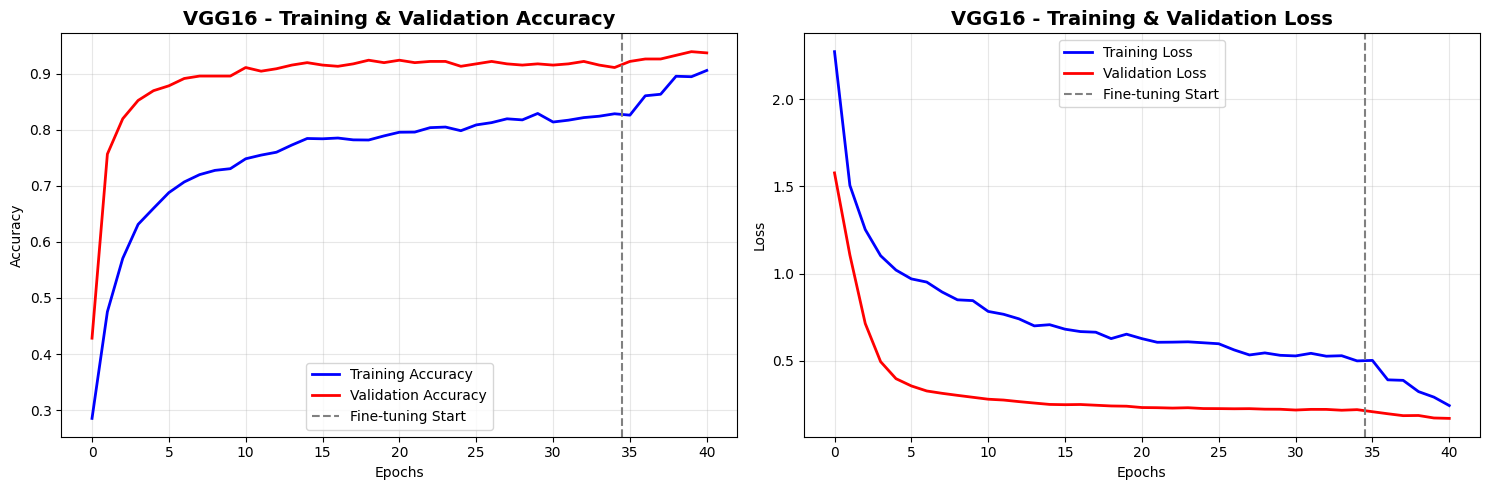


Evaluating VGG16 on test set...



VGG16 - FINAL RESULTS
TRAINING PHASE:
   Final Training Accuracy:   0.9056
   Final Training Loss:       0.2427
   Final Validation Accuracy: 0.9370
   Final Validation Loss:     0.1692

TEST PHASE:
   Test Accuracy:             0.9087
   Test Loss:                 0.2621

PERFORMANCE SUMMARY:
   Accuracy Drop (Val -> Test): +0.0283
   Loss Increase (Val -> Test): +0.0928
   Good generalization - model is not overfitting significantly
VGG16 model saved as 'saved_models/VGG16_betel_disease.h5'


In [23]:
print("\n" + "="*80)
print("7. TRAINING AND EVALUATING VGG16")
print("="*80)

# Create VGG16 model
vgg16_model, vgg16_base = create_vgg16_model()
print("VGG16 model created successfully!")
print(f"   Total parameters: {vgg16_model.count_params():,}")

# Define callbacks
vgg16_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('saved_models/best_VGG16.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Phase 1: Train with frozen base model
print("\nPhase 1: Training VGG16 with frozen base model...")
vgg16_history = vgg16_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=vgg16_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save training history
save_training_history(vgg16_history, "VGG16_phase1")

# Phase 2: Fine-tuning
print("\nPhase 2: Fine-tuning VGG16...")
vgg16_base.trainable = True

# Fine-tune from later blocks (keep early layers frozen)
for layer in vgg16_base.layers[:15]:  # Freeze first 15 layers
    layer.trainable = False

vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001/10),  # Very low LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

vgg16_history_fine = vgg16_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=vgg16_history.epoch[-1],
    validation_data=val_dataset,
    callbacks=vgg16_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Save fine-tuning history
save_training_history(vgg16_history_fine, "VGG16_phase2")

# Plot training history
plot_training_history(vgg16_history, vgg16_history_fine, "VGG16")

# Evaluate on test set
print("\nEvaluating VGG16 on test set...")
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_dataset, verbose=0)

# Print results
print_model_results("VGG16", vgg16_history, vgg16_history_fine, vgg16_test_loss, vgg16_test_accuracy)

# Store results
all_models_results["VGG16"] = {
    'train_accuracy': vgg16_history_fine.history['accuracy'][-1],
    'train_loss': vgg16_history_fine.history['loss'][-1],
    'val_accuracy': vgg16_history_fine.history['val_accuracy'][-1],
    'val_loss': vgg16_history_fine.history['val_loss'][-1],
    'test_accuracy': vgg16_test_accuracy,
    'test_loss': vgg16_test_loss
}

# Save model
vgg16_model.save('saved_models/VGG16_betel_disease.h5')
print("VGG16 model saved as 'saved_models/VGG16_betel_disease.h5'")

In [20]:
#### Load model and training history

In [21]:
import pandas as pd
from tensorflow import keras
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

In [22]:
# Extract full test images and labels from your tf.data.Dataset
test_images = []
test_labels = []

for img_batch, lbl_batch in test_dataset:
    test_images.append(img_batch.numpy())
    test_labels.append(lbl_batch.numpy())

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

print(f"Test data ready → Images: {test_images.shape}, Labels: {test_labels.shape}")
print(f"Label type: {test_labels.dtype} | Sample labels: {test_labels[:10]}")

Test data ready → Images: (460, 224, 224, 3), Labels: (460,)
Label type: int64 | Sample labels: [1 2 2 2 6 5 3 5 6 0]


In [23]:
%matplotlib inline
plt.style.use('default')
sns.set_style("whitegrid")

In [24]:
def load_model_and_history(model_path, history_path):
    try:
        model = keras.models.load_model(model_path)
        print(f"Loaded model: {os.path.basename(model_path)}")
    except Exception as e:
        print(f"Failed model {model_path}: {e}")
        return None, None

    history = {}
    if os.path.exists(history_path):
        try:
            with open(history_path, 'rb') as f:
                hist_data = pickle.load(f)
                
                if isinstance(hist_data, dict):
                    history = hist_data
                else:
                    history = {k: v for k, v in hist_data.history.items()}
            print(f"Loaded history: {os.path.basename(history_path)}")
        except:
            print(f"Could not load history: {history_path}")
    return model, history


def evaluate_model(model, X_test, y_test_sparse):
    preds = model.predict(X_test, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = y_test_sparse

    
    test_loss, test_acc_from_model = model.evaluate(X_test, y_test_sparse, verbose=0)

    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'test_loss': test_loss,
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'macro_f1': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'weighted_f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'predicted_classes': y_pred,
        'true_classes': y_true
    }


def run_comparison(model_configs, class_names=CLASS_NAMES):
    results = []
    print("MODEL COMPARISON STARTED\n" + "="*90)

    for i, (model_path, history_path) in enumerate(model_configs, 1):
        print(f"\n[{i}/{len(model_configs)}] Evaluating {os.path.basename(model_path)}")

        model, history = load_model_and_history(model_path, history_path)
        if model is None:
            continue

        metrics = evaluate_model(model, test_images, test_labels)
        model_name = os.path.basename(model_path).replace('.h5', '').replace('.keras', '')

        print(f"  Test Accuracy: {metrics['accuracy']:.4f} | Macro F1: {metrics['macro_f1']:.4f}")

        results.append({
            'model_name': model_name,
            'history': history,
            **metrics
        })

    if not results:
        print("No models loaded!")
        return None, None

    # Comparison Table
    table = []
    for r in results:
        h = r['history']
        train_acc = h.get('accuracy', [0])[-1] if h else None
        val_acc = h.get('val_accuracy', [0])[-1] if h else None

        table.append({
            'Model': r['model_name'],
            'Test Acc': f"{r['accuracy']:.4f}",
            'Macro F1': f"{r['macro_f1']:.4f}",
            'Weighted F1': f"{r['weighted_f1']:.4f}",
            'Train Acc': f"{train_acc:.4f}" if train_acc else "-",
            'Val Acc': f"{val_acc:.4f}" if val_acc else "-",
        })

    df = pd.DataFrame(table)
    print("\n" + "="*100)
    print("FINAL RESULTS TABLE")
    print("="*100)
    print(df.to_string(index=False))

    # Best model
    best = max(results, key=lambda x: x['accuracy'])
    print(f"\nBEST MODEL → {best['model_name']}")
    print(f"   Test Accuracy : {best['accuracy']:.4f}")
    print(f"   Macro F1      : {best['macro_f1']:.4f}")

    # Plots
    fig = plt.figure(figsize=(18, 12))

    # Accuracy curves
    plt.subplot(2, 3, 1)
    for r in results:
        h = r['history']
        if h and 'accuracy' in h:
            plt.plot(h['accuracy'], label=f"{r['model_name']} Train")
            if 'val_accuracy' in h:
                plt.plot(h['val_accuracy'], '--', label=f"{r['model_name']} Val")
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Loss curves
    plt.subplot(2, 3, 2)
    for r in results:
        h = r['history']
        if h and 'loss' in h:
            plt.plot(h['loss'], label=f"{r['model_name']} Train")
            if 'val_loss' in h:
                plt.plot(h['val_loss'], '--', label=f"{r['model_name']} Val")
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Test Accuracy Bar
    plt.subplot(2, 3, 3)
    names = [r['model_name'] for r in results]
    accs = [r['accuracy'] for r in results]
    bars = plt.bar(names, accs, color=['#4e79a7','#f28e2b','#e15759','#76b7b2','#59a14f'][:len(names)])
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f"{bar.get_height():.4f}", ha='center', va='bottom')

    # Confusion Matrices
    for idx, r in enumerate(results):
        plt.subplot(2, len(results), len(results) + 1 + idx)
        sns.heatmap(r['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, cbar=False)
        plt.title(f"{r['model_name']}")
        plt.xlabel('Pred')
        plt.ylabel('True')

    plt.tight_layout()
    plt.show()

    return results, df

MODEL COMPARISON STARTED

[1/6] Evaluating ResNet50_betel_disease.h5


Loaded model: ResNet50_betel_disease.h5
Loaded history: ResNet50_phase2_history_20251128_171710.pkl
  Test Accuracy: 0.0826 | Macro F1: 0.0220

[2/6] Evaluating MobileNetV3_betel_disease.h5
Failed model saved_models/MobileNetV3_betel_disease.h5: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 3.0 (of type <class 'float'>)

[3/6] Evaluating DenseNet121_betel_disease.h5


Loaded model: DenseNet121_betel_disease.h5
Loaded history: DenseNet121_phase2_history_20251129_112829.pkl
  Test Accuracy: 0.9630 | Macro F1: 0.9564

[4/6] Evaluating InceptionV3_betel_disease.h5


Loaded model: InceptionV3_betel_disease.h5
Loaded history: InceptionV3_phase2_history_20251129_152130.pkl
  Test Accuracy: 0.8957 | Macro F1: 0.8707

[5/6] Evaluating VGG16_betel_disease.h5


Loaded model: VGG16_betel_disease.h5
Loaded history: VGG16_phase2_history_20251203_095054.pkl
  Test Accuracy: 0.9087 | Macro F1: 0.8866

[6/6] Evaluating best_ConvNeXt.h5
Failed model saved_models/best_ConvNeXt.h5: Unknown layer: 'LayerScale'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

FINAL RESULTS TABLE
                    Model Test Acc Macro F1 Weighted F1 Train Acc Val Acc
   ResNet50_betel_disease   0.0826   0.0220      0.0127    0.7574  0.6826
DenseNet121_betel_disease   0.9630   0.9564      0.9631    0.9861  0.9674
InceptionV3_betel_disease   0.8957   0.8707      0.8960    0.9432  0.9065
      VGG16_betel_disease   0.9087   0.8866      0.9084    0.9056  0.9370

BEST MODEL → DenseNet121_betel_disease
   Test Accuracy : 0.9630
   Macro F1      : 0.9564


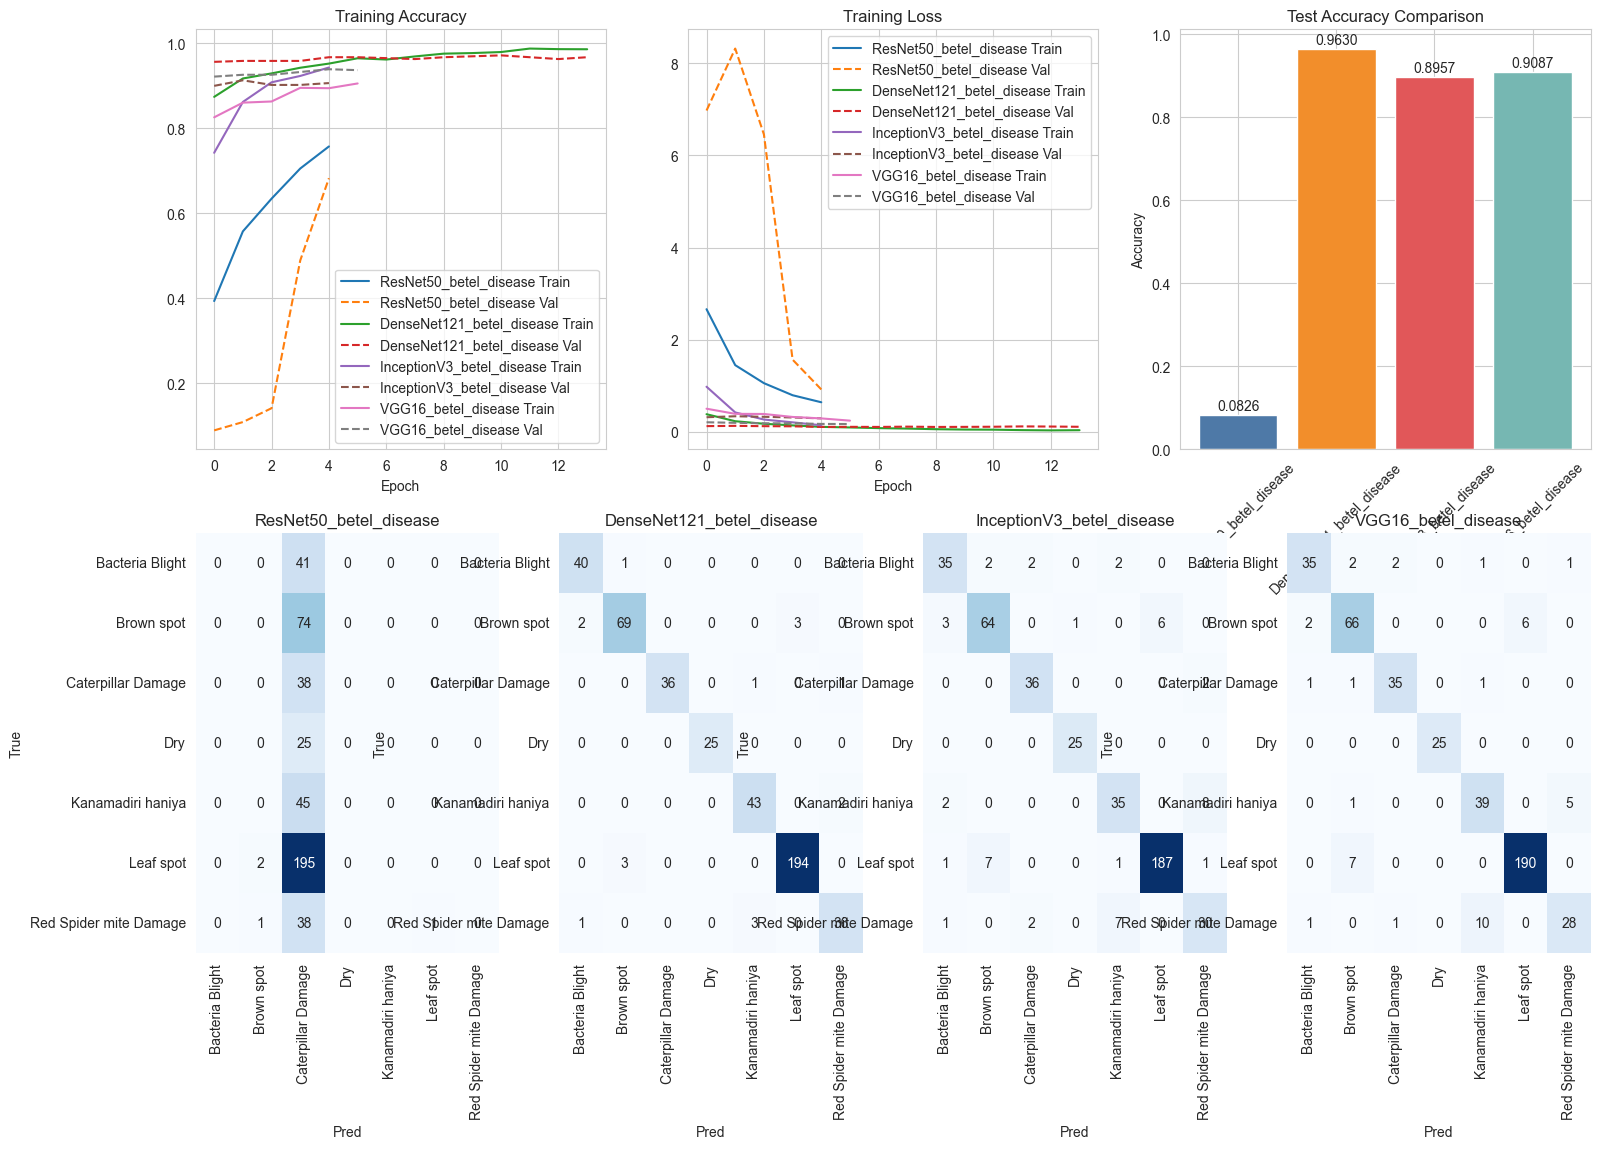

In [25]:
model_configs = [
    ("saved_models/ResNet50_betel_disease.h5",        "training_history/ResNet50_phase2_history_20251128_171710.pkl"),
    ("saved_models/MobileNetV3_betel_disease.h5",     "training_history/MobileNetV3_phase2_history_20251128_181838.pkl"),
    ("saved_models/DenseNet121_betel_disease.h5",     "training_history/DenseNet121_phase2_history_20251129_112829.pkl"),
    ("saved_models/InceptionV3_betel_disease.h5",     "training_history/InceptionV3_phase2_history_20251129_152130.pkl"),
    ("saved_models/VGG16_betel_disease.h5",     "training_history/VGG16_phase2_history_20251203_095054.pkl"),
    ("saved_models/best_ConvNeXt.h5",     "training_history/ConvNeXt_phase1_history_20251213_041133.pkl")
]

results, summary_table = run_comparison(model_configs, CLASS_NAMES)